**WEEK1**

**EchoWater-AI Based Water Pollution Detection**

**PROBLEM STATEMENT**

Water pollution threatens ecosystems and human health; this project uses AI to automatically detect and classify polluted water for faster and more reliable monitoring


STEP 1:Import libraries

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np



STEP 2:Load Dataset

In [3]:
from google.colab import files
import zipfile

# Upload ZIP file (your dataset)
uploaded = files.upload()

# Get uploaded file name
zip_file = next(iter(uploaded))

# Extract ZIP into 'dataset' folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall("dataset")

print("✅ Files extracted to 'dataset/' folder")





Saving water images (3).zip to water images (3).zip
✅ Files extracted to 'dataset/' folder


In [4]:
import os

train_path = "dataset/water images (2)/water images"   # correct location

for folder in os.listdir(train_path):
    count = len(os.listdir(os.path.join(train_path, folder)))
    print(folder, ":", count, "images")

Clean-samples : 162 images
Dirty-samples : 130 images


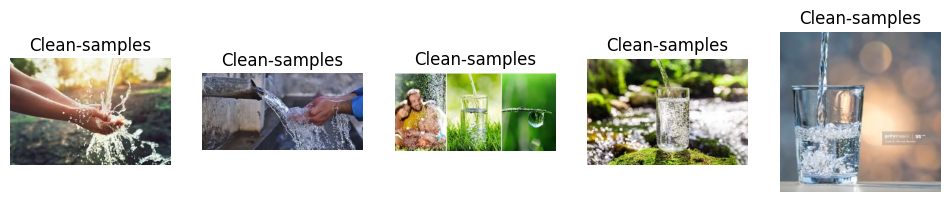

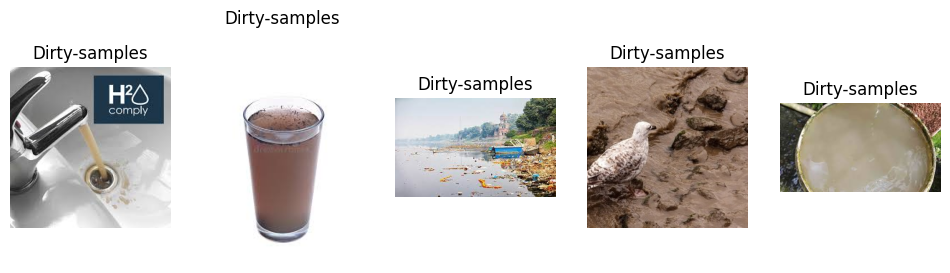

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display 5 sample images from each class
classes = ["Clean-samples", "Dirty-samples"]

for cls in classes:
    folder_path = os.path.join(train_path, cls)
    sample_images = os.listdir(folder_path)[:5]

    plt.figure(figsize=(12, 3))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(cls)
    plt.show()


STEP 3:Explore Dataset

Before training any model, we need to understand the dataset. We will:

.Check total number of images .See distribution of classes .Look for missing values .View a random sample image

In [6]:
from PIL import Image

# 1. Check number of classes
classes = os.listdir(train_path)
print("Classes:", classes)

# 2. Count images in each class
for cls in classes:
    folder_path = os.path.join(train_path, cls)
    print(f"{cls}: {len(os.listdir(folder_path))} images")

# 3. Check image shapes (take first image from each class)
for cls in classes:
    folder_path = os.path.join(train_path, cls)
    sample_img = os.listdir(folder_path)[0]
    img_path = os.path.join(folder_path, sample_img)
    img = Image.open(img_path)
    print(f"{cls} sample image shape: {img.size}, mode: {img.mode}")

# 4. Check for corrupted images
corrupted = 0
for cls in classes:
    folder_path = os.path.join(train_path, cls)
    for img_name in os.listdir(folder_path):
        try:
            img = Image.open(os.path.join(folder_path, img_name))
            img.verify()
        except:
            corrupted += 1

print("Number of corrupted images:", corrupted)

Classes: ['Clean-samples', 'Dirty-samples']
Clean-samples: 162 images
Dirty-samples: 130 images
Clean-samples sample image shape: (275, 183), mode: RGB
Dirty-samples sample image shape: (225, 225), mode: RGB
Number of corrupted images: 0


**WEEK 2**

**EchoWater-AI Based Water Pollution Detection**

**FOCUS:**

in this week ,we move from dataset prepation to training and testing models

In [ ]:
import os, shutil, random
from glob import glob

# Change this path if your dataset folder name is different
source_root = "dataset/water images (2)/water images"   # update if needed
target_root = "dataset_split"

# Split ratios
splits = {"train": 0.70, "val": 0.15, "test": 0.15}

# Get class folders (like Clean-samples / Dirty-samples)
classes = [d for d in os.listdir(source_root) if os.path.isdir(os.path.join(source_root, d))]
print("Classes found:", classes)

# Create train/val/test directories
for split in splits:
    for cls in classes:
        os.makedirs(os.path.join(target_root, split, cls), exist_ok=True)

# Supported extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Split and copy
for cls in classes:
    files = [p for p in glob(os.path.join(source_root, cls, "*"))
             if os.path.splitext(p)[1].lower() in IMG_EXTS]
    random.shuffle(files)
    n = len(files)
    n_train = int(n * splits["train"])
    n_val = int(n * splits["val"])

    train_files = files[:n_train]
    val_files = files[n_train:n_train + n_val]
    test_files = files[n_train + n_val:]

    for split_name, file_list in zip(["train", "val", "test"],
                                     [train_files, val_files, test_files]):
        for src in file_list:
            dst = os.path.join(target_root, split_name, cls, os.path.basename(src))
            if not os.path.exists(dst):
                shutil.copy2(src, dst)

# Quick check
for split in ["train", "val", "test"]:
    counts = {cls: len(os.listdir(os.path.join(target_root, split, cls))) for cls in classes}
    print(f"{split}:", counts)


Classes found: ['Clean-samples', 'Dirty-samples']
train: {'Clean-samples': 113, 'Dirty-samples': 91}
val: {'Clean-samples': 24, 'Dirty-samples': 19}
test: {'Clean-samples': 25, 'Dirty-samples': 20}


STEP 4:data preprocessing

Normalize pixel values

Resize all images to a uniform shape

Split dataset into train, validation, and test sets

In [ ]:
import os, shutil, random
from glob import glob

# Source (your dataset with Clean-samples & Dirty-samples)
source_root = "dataset/water images (2)/water images"  # 👈 change path if different
target_root = "dataset_split"

# Split ratios
splits = {"train": 0.70, "val": 0.15, "test": 0.15}

# Map old folder names to simpler ones
rename_map = {
    "Clean-samples": "clean",
    "Dirty-samples": "dirty"
}

# Create split directories
for split in splits:
    for new_cls in rename_map.values():
        os.makedirs(os.path.join(target_root, split, new_cls), exist_ok=True)

# Supported extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# Copy files into splits
for old_cls, new_cls in rename_map.items():
    files = [p for p in glob(os.path.join(source_root, old_cls, "*"))
             if os.path.splitext(p)[1].lower() in IMG_EXTS]
    random.shuffle(files)
    n = len(files)
    n_train = int(n * splits["train"])
    n_val = int(n * splits["val"])

    for i, f in enumerate(files):
        if i < n_train:
            split = "train"
        elif i < n_train + n_val:
            split = "val"
        else:
            split = "test"

        shutil.copy(f, os.path.join(target_root, split, new_cls))

print("✅ Dataset successfully split into train/val/test folders")


✅ Dataset successfully split into train/val/test folders


In [ ]:
# Cell 6: Load train/val/test datasets
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_split/train",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_split/val",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset_split/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# ✅ Get class names before prefetch
class_names = train_ds.class_names
print("✅ Classes:", class_names)

# Now prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)




Found 204 files belonging to 2 classes.
Found 43 files belonging to 2 classes.
Found 45 files belonging to 2 classes.
✅ Classes: ['Clean-samples', 'Dirty-samples']


STEP 5:Build Model

We use a Convolutional Neural Network (CNN) built from scratch in Keras to classify our water pollution dataset.

.Input size: 224 × 224 × 3 images

.Apply data augmentation (flip, rotation, zoom)

.Normalize pixel values with Rescaling (1./255)

.Convolution + MaxPooling layers to extract features

.Flatten layer to convert features into a vector

.Dropout (0.3) to reduce overfitting

.Dense(64, relu) fully connected layer

.Final layer uses Softmax for multi-class outputs

STEP 6: Train Model

We train the CNN on our dataset.

*   use an optimizer
*   moniter loss and accuracy on valiation data







Metric: Accuracy

In [ ]:
from tensorflow.keras import layers, models

# ✅ Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# ✅ CNN Model with explicit input shape
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),   # 👈 Explicit input layer
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Show model summary
model.summary()




Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,631,234 (21.48 MB)

 Trainable params: 5,631,234 (21.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,          # you can try 20–25 for better accuracy
    verbose=1
)


Epoch 1/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.5629 - loss: 2.6042 - val_accuracy: 0.4419 - val_loss: 0.7005
Epoch 2/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 4s/step - accuracy: 0.5528 - loss: 0.6879 - val_accuracy: 0.5814 - val_loss: 0.5990
Epoch 3/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.5682 - loss: 0.6306 - val_accuracy: 0.7442 - val_loss: 0.5815
Epoch 4/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.6104 - loss: 0.6184 - val_accuracy: 0.6977 - val_loss: 0.5989
Epoch 5/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.6536 - loss: 0.6298 - val_accuracy: 0.6744 - val_loss: 0.5485
Epoch 6/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.6798 - loss: 0.5842 - val_accuracy: 0.6977 - val_loss: 0.5186
Epoch 7/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 4s/step - accuracy: 0.6772 - loss: 0.5617 - val_accuracy: 0.6744 - val_loss: 0.5375
Epoch 8/15
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 4s/step - accuracy: 0.5847 - loss: 0.6077 - val_accuracy: 0.6977 - val_loss: 0.5069
Epoch 9/

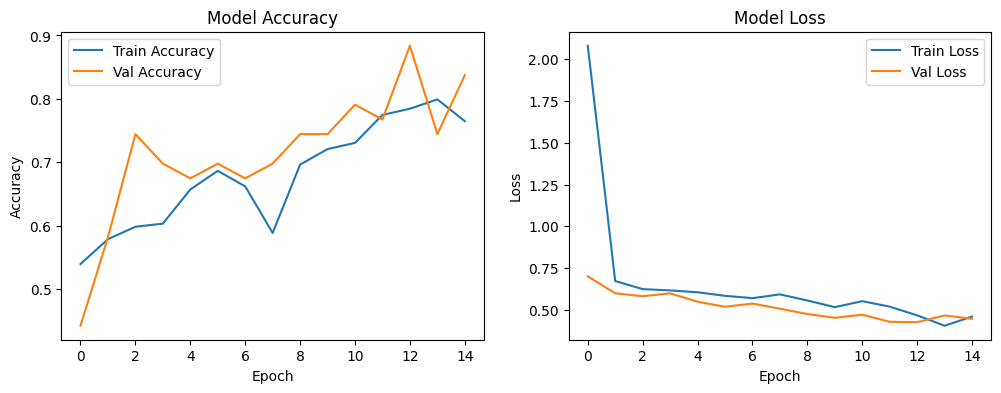

In [ ]:
import matplotlib.pyplot as plt

# ✅ Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()




In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {test_acc:.2f}, Test Loss: {test_loss:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 355ms/step - accuracy: 0.7537 - loss: 0.5358
✅ Test Accuracy: 0.76, Test Loss: 0.5302


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


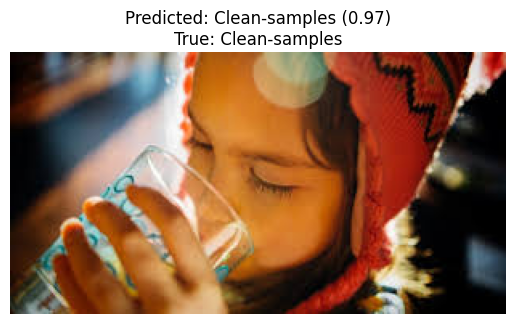

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

# Pick a random class folder
random_class = random.choice(class_names)
class_folder = os.path.join("dataset_split/test", random_class)

# Pick a random image from that class
random_img = random.choice(os.listdir(class_folder))
img_path = os.path.join(class_folder, random_img)

# Load and preprocess
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
predictions = model.predict(img_array)
predicted_class = class_names[np.argmax(predictions[0])]
confidence = np.max(predictions[0])

# Show results
plt.imshow(image.load_img(img_path))
plt.axis("off")
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})\nTrue: {random_class}")
plt.show()



In [ ]:
import os

for split in ["train", "val", "test"]:
    print(f"\n{split.upper()}:")
    for cls in class_names:
        count = len(os.listdir(os.path.join("dataset_split", split, cls)))
        print(f"  {cls}: {count} images")


TRAIN:
  Clean-samples: 113 images
  Dirty-samples: 91 images

VAL:
  Clean-samples: 24 images
  Dirty-samples: 19 images

TEST:
  Clean-samples: 25 images
  Dirty-samples: 20 images


In [ ]:
import numpy as np

y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

from collections import Counter
print("Predicted counts:", Counter(y_pred))
print("True counts:", Counter(y_true))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Predicted counts: Counter({np.int64(1): 23, np.int64(0): 22})
True counts: Counter({np.int32(0): 25, np.int32(1): 20})


STEP 7: Evaluate Model

We evaluate the trained CNN on the test dataset

Class names: ['Clean-samples', 'Dirty-samples']


Saving Screenshot 2025-09-04 214552.png to Screenshot 2025-09-04 214552 (2).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


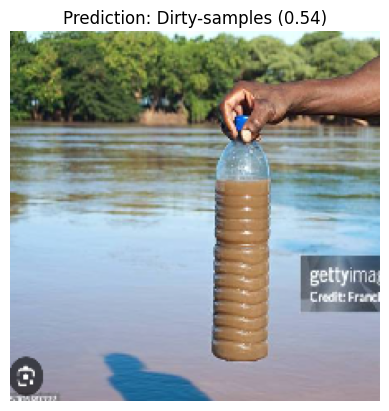

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

print("Class names:", class_names)  # so you know index → label mapping

# Upload image(s)
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = "/content/" + fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)          # 0..255
    img_array = np.expand_dims(img_array, axis=0)  # DO NOT /255.0 (model already rescales)

    # Predict
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_names[pred_class]} ({confidence:.2f})")
    plt.show()


Class names: ['Clean-samples', 'Dirty-samples']


Saving Screenshot 2025-09-04 222215.png to Screenshot 2025-09-04 222215 (1).png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


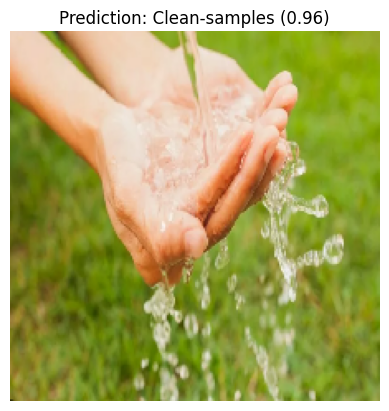

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

print("Class names:", class_names)  # so you know index → label mapping

# Upload image(s)
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = "/content/" + fn
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)          # 0..255
    img_array = np.expand_dims(img_array, axis=0)  # DO NOT /255.0 (model already rescales)

    # Predict
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    # Show result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_names[pred_class]} ({confidence:.2f})")
    plt.show()